### Data

1. 311_2015.csv -- Herni uploaded in slack
2. ct_shape.shp -- The One we used in PUI_HW10 to calculate the area of NYC.
3. Location of Dropin centers are input manually.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import pylab as pl
%pylab inline
import rtree
import scipy.stats as stats
from fiona.crs import from_epsg

Populating the interactive namespace from numpy and matplotlib


### 1.Read CSV File

In [2]:
df = pd.read_csv("311_2015.csv")
df = df.dropna() #important!!! especially for col = Lon & Lat
print df.shape
df.head()

(11764, 7)


,Unnamed: 0,Unique Key,Created Date,Incident Zip,Latitude,Longitude,City
0,21,30341247,04/07/2015 01:31:29 AM,11205.0,40.693205,-73.953990,BROOKLYN
1,36,30339846,04/07/2015 01:05:00 AM,11215.0,40.664132,-73.986368,BROOKLYN
2,524,30338420,04/06/2015 09:15:20 PM,11222.0,40.721795,-73.948032,BROOKLYN
3,878,30343247,04/06/2015 07:13:21 PM,11215.0,40.660374,-73.978594,BROOKLYN
4,1442,30344376,04/06/2015 04:23:11 PM,10003.0,40.733861,-73.990958,NEW YORK


### 2.Covert df into gpd.Dataframe by adding 'geometry'

In [4]:
# make sure 'Lon-Lat' are numeric variable
type(df.Latitude.values[0])

numpy.float64

In [5]:
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Following code is another way to create 'geometry':
# geometry = gpd.GeoSeries([Point(xy) for xy in zip(df.Longitude, df.Latitude)])

In [6]:
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'])
# set coordinate system
gdf.crs = {"init": "epsg:4326"}
gdf.head(2)

,Unnamed: 0,Unique Key,Created Date,Incident Zip,Latitude,Longitude,City,geometry
0,21,30341247,04/07/2015 01:31:29 AM,11205.0,40.693205,-73.953990,BROOKLYN,POINT (-73.95398996627262 40.6932048467267)
1,36,30339846,04/07/2015 01:05:00 AM,11215.0,40.664132,-73.986368,BROOKLYN,POINT (-73.98636773266445 40.66413235965906)


In [7]:
gdf.crs

{'init': 'epsg:4326'}

### 3. Create a list of Homeless Drop-In Center in NYC

In [8]:
# Tips: {"Name": [list]}
dropin = gpd.GeoDataFrame({"Name": ['Mainchance'], "Address": ["120 East 32nd St. in East Midtown"], "Zipcode": ["10016"], 
          "geometry": [Point(-73.9814622, 40.7452285)]}, geometry = 'geometry') 
dropin = dropin.append(gpd.GeoDataFrame({"Name": ['The Living Room'] ,"Address": ["800 Barretto St., Bronx"], 
                                "Zipcode": ["10474"], "geometry": [Point(-73.8916751, 40.8168537)]}, 
                               geometry = 'geometry'))
dropin = dropin.append(gpd.GeoDataFrame({"Name": ['Olivieri Center'], "Address": ["257 West 30th St. near Penn Station"], 
                                "Zipcode": ["10001"], "geometry": [Point(-73.9966147, 40.7495275)]}, 
                               geometry = 'geometry'))
dropin = dropin.append(gpd.GeoDataFrame({"Name": ['The Gathering Place'], "Address": ["2402 Atlantic Ave. in Brooklyn"], 
                                "Zipcode": ["11233"], "geometry": [Point(-73.9075159, 40.6757497)]}, 
                               geometry = 'geometry'))
dropin = dropin.append(gpd.GeoDataFrame({"Name": ['Project Hospitality'], "Address": ["25 Central Ave. in Staten Island"], 
                                "Zipcode": ["10301"], "geometry": [Point(-74.0787456, 40.641182)]}, 
                               geometry = 'geometry'))
dropin.crs = {"init": "epsg:4326"}

In [9]:
dropin = dropin.reset_index(drop = True)

In [10]:
dropin

,Address,Name,Zipcode,geometry
0,120 East 32nd St. in East Midtown,Mainchance,10016,POINT (-73.9814622 40.7452285)
1,"800 Barretto St., Bronx",The Living Room,10474,POINT (-73.8916751 40.8168537)
2,257 West 30th St. near Penn Station,Olivieri Center,10001,POINT (-73.99661469999999 40.7495275)
3,2402 Atlantic Ave. in Brooklyn,The Gathering Place,11233,POINT (-73.90751590000001 40.6757497)
4,25 Central Ave. in Staten Island,Project Hospitality,10301,POINT (-74.0787456 40.641182)


#### We can use Google API to get all Lon-Lat data of Drop-In centers in NYC.

### 4. Create Buffer of Drop-In Center and Spatial Join with 311 Points

In [11]:
b = dropin.copy()
b1 = dropin.copy()
b01 = dropin.copy()
b1['geometry'] = b.buffer(0.005,resolution=20) #see instruction about how to set parameters.
b01['geometry'] = b.buffer(0.001,resolution=20)
#? still confused about the unit(mile/feet/meter/km) of "buffer".

b1.crs={"init": "epsg:4326"}
b01.crs={"init": "epsg:4326"}

In [12]:
# 311 with buffer
complaint_buffer1 = gpd.sjoin(b1, gdf)
complaint_buffer01 = gpd.sjoin(b01, gdf)

In [13]:
print gdf.shape
print complaint_buffer1.shape
print complaint_buffer01.shape

(11764, 8)
(334, 12)
(30, 12)


In [14]:
b01

,Address,Name,Zipcode,geometry
0,120 East 32nd St. in East Midtown,Mainchance,10016,"POLYGON ((-73.98046219999999 40.7452285, -73.9..."
1,"800 Barretto St., Bronx",The Living Room,10474,"POLYGON ((-73.8906751 40.8168537, -73.89067818..."
2,257 West 30th St. near Penn Station,Olivieri Center,10001,"POLYGON ((-73.99561469999999 40.7495275, -73.9..."
3,2402 Atlantic Ave. in Brooklyn,The Gathering Place,11233,"POLYGON ((-73.9065159 40.6757497, -73.90651898..."
4,25 Central Ave. in Staten Island,Project Hospitality,10301,"POLYGON ((-74.0777456 40.641182, -74.077748682..."


### 5.Normalization of buffer

In [15]:
#area of buffer
print b1.area
print b01.area

0    0.000078
1    0.000078
2    0.000078
3    0.000078
4    0.000078
dtype: float64
0    0.000003
1    0.000003
2    0.000003
3    0.000003
4    0.000003
dtype: float64


In [16]:
# the number of complaints per square unit (maybe sqft?)
print complaint_buffer01.shape[0] / b01.area
print (complaint_buffer1.shape[0] - complaint_buffer01.shape[0]) / (b1.area - b01.area)

0    9.559121e+06
1    9.559121e+06
2    9.559121e+06
3    9.559121e+06
4    9.559121e+06
dtype: float64
0    4.036073e+06
1    4.036073e+06
2    4.036073e+06
3    4.036073e+06
4    4.036073e+06
dtype: float64


<br/><br/>
## 6. From single Buffer to multiple RingBuffer

In [17]:
# 1. ring-buffer
def circles(radius, df):
    '''
    radius: list
    df: df with geometry 'Polygon'
    return: Circles not Rings, eg. b['0.001']
    '''
    b = {}
    for r in radius:
        temp = df.copy()
        temp['geometry'] = temp.buffer(r)
        temp.crs = from_epsg(4326)
        name = str(r) 
        b[name] = temp
    return b 

# 2. sjoin: (Polygon, Points) - counts
def circleSJoin(radius, b, df_points):
    '''
    b: circles (buffer)
    df_points: df with geometry "Points"
    return: Circle not Ring with # of Points in each, eg. b_sjoin['0.001']
    '''
    c_sjoin = {}
    for i, r in enumerate(b):
        name = str(radius[i])
        temp = b[name].copy()
        temp.crs = df_points.crs
        c_sjoin[name] = gpd.sjoin(temp, df_points)
    return c_sjoin 

# 3. ringDensity
def Density(radius, circles, c_sjoin):
    rAreas = {}
    rCounts = {}
    rDesity = {} 
    rDesity_list = []
    for i in xrange(len(radius)):
        name = str(radius[i])
        if i == 0:
            rAreas[name] = circles[name].area.sum()
            rCounts[name] = c_sjoin[name].shape[0] 
        else:
            inside= str(radius[i-1])
            rAreas[name] = circles[name].area.sum() - circles[inside].area.sum()
            rCounts[name] = c_sjoin[name].shape[0] - c_sjoin[inside].shape[0]
        rDesity[name] = rCounts[name] / rAreas[name]
        rDesity_list.append(rDesity[name])
    return rDesity, rCounts, rAreas, rDesity_list

# 4
def ringDensity(radius, df_polygon, df_point):
    c = circles(radius, df_polygon)
    bs = circleSJoin(radius, c, df_point)
    density, count, area, density_list = Density(radius, c, bs)
    return density, count, area, density_list  

In [18]:
r = [0.0005, 0.0006, 0.00075, 0.001, 0.00125, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.010, 0.015, 0.02]
#c =circles(r, dropin)
#bs = circleSJoin(r, c, gdf)
# Density(r, c, bs)
r_density, r_count, r_area, r_density_list  = ringDensity(r, dropin, gdf)

##### Result above is mainly used to test whether the sequential values in the list is from certain distribution 
##### eg. KS Test / Aderson Test -> Exponential 
##### which to some degree proves the density is much higher with the increasing radius (within certain distance, not too far). 

In [19]:
r_count

{'0.0005': 2,
 '0.0006': 8,
 '0.00075': 2,
 '0.001': 18,
 '0.00125': 12,
 '0.0015': 14,
 '0.002': 18,
 '0.003': 85,
 '0.005': 175,
 '0.007': 361,
 '0.01': 515,
 '0.015': 1805,
 '0.02': 2372}

In [20]:
r_density_list

[510114.8618682025,
 4637407.8351553865,
 629771.4344038005,
 2623447.86104614,
 1360306.298314213,
 1298474.1938541874,
 655861.9652586596,
 1083994.0814721005,
 697422.6627113973,
 959122.2142433446,
 643894.9849572188,
 920757.3256734515,
 864280.323109167]

(400000, 5000000)

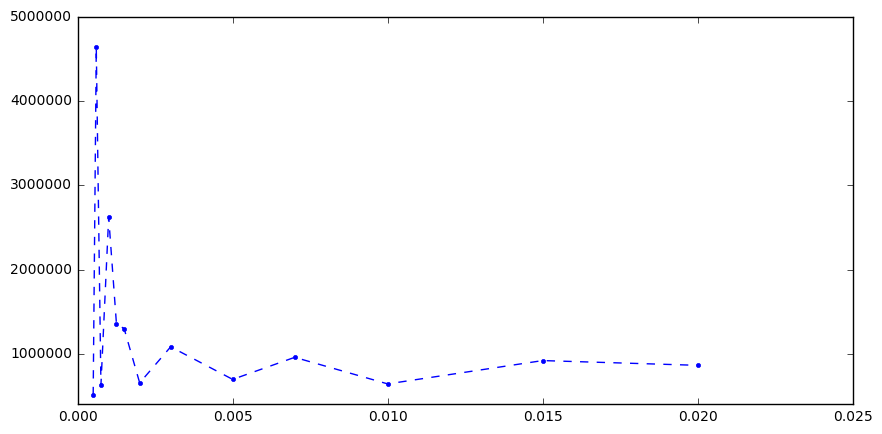

In [26]:
pl.figure(figsize=(10,5))
pl.plot(r, r_density_list, '.--')
pl.ylim(400000,5000000)

### Not Only Do Hypo Test, We Can Show the Trends in some more Intuitive Plot. 
### Not Do Hypo Test Yet! 
### Reset Range of Radius, Need More Experiments.

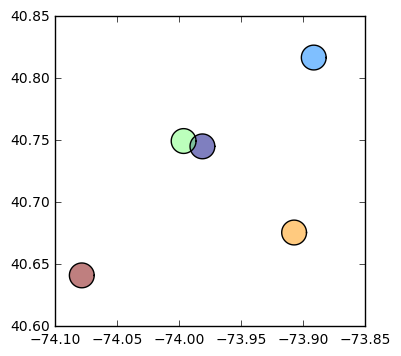

In [27]:
# overlay parts count twice.
ring = circles(r, dropin)
ring[str(r[10])].plot()

### NYC Areas and Complaint Couts

### Figure out densities of 6 dropin buffer each. 
### Hypo test (z/t) with density of NYC.

In [28]:
nyc = gpd.read_file("CT_Shape/ct_shape.shp")

In [29]:
nyc_density = gdf.shape[0] / nyc.area.sum()
print "The 311 Homeless Encampment Complaints Density of NYC is {:.3f}.\n\
The Area of NYC is Around {:.3f} Units^2.\n\
The Number of Homeless Encampment Complaints is {}.".format(nyc_density, nyc.area.sum(),gdf.shape[0])

The 311 Homeless Encampment Complaints Density of NYC is 140986.361.
The Area of NYC is Around 0.083 Units^2.
The Number of Homeless Encampment Complaints is 11764.


In [30]:
r=[0.002] # other values?
dropin_density = []
dropin_count = []
for i in xrange(dropin.shape[0]):
    r_density, r_count, r_area, r_density_list  = ringDensity(r, dropin.iloc[[i]], gdf)
    dropin_density.append(r_density_list[0])
    dropin_count.append(r_count[str(r[0])])
print dropin_density,'\n', dropin_count

[3586745.122513895, 239116.34150092636, 1594108.943339509, 398527.23583487724, 79705.44716697544] 
[45, 3, 20, 5, 1]


In [31]:
stats.ttest_1samp(dropin_density, nyc_density)

Ttest_1sampResult(statistic=1.5774786632630269, pvalue=0.18982098498085073)

### Sadly we can not reject Null hypo. r=0.002. MAYBE 'unit' matters.

<br/><br/>
### Also set buffer r=1 unit as population instead of NYC.

In [32]:
r=[0.005] 
dropin_density = []
dropin_count = []
for i in xrange(dropin.shape[0]):
    r_density, r_count, r_area, r_density_list  = ringDensity(r, dropin.iloc[[i]], gdf)
    dropin_density.append(r_density_list[0])
    dropin_count.append(r_count[str(r[0])])
print dropin_density,'\n', dropin_count
a = dropin_density

[2512315.6947044735, 127528.71546723215, 1300792.897765768, 204045.94474757143, 114775.84392050894] 
[197, 10, 102, 16, 9]


In [33]:
r=[1] 
dropin_density = []
dropin_count = []
for i in xrange(dropin.shape[0]):
    r_density, r_count, r_area, r_density_list  = ringDensity(r, dropin.iloc[[i]], gdf)
    dropin_density.append(r_density_list[0])
    dropin_count.append(r_count[str(r[0])])
print dropin_density,'\n', dropin_count
b = dropin_density

[3750.619521891211, 3750.619521891211, 3750.6195218912103, 3750.6195218912103, 3750.6195218912103] 
[11764, 11764, 11764, 11764, 11764]


In [34]:
stats.ttest_1samp(a,mean(b))

Ttest_1sampResult(statistic=1.7988106446155561, pvalue=0.14644091500683593)

### Not Reject Null Hypo

<br/><br/><br/>


<br/><br/> 
## Note

#### 24-HOUR DROP-IN CENTERS FOR ADULTS : http://www1.nyc.gov/assets/dhs/downloads/pdf/intake_drop_in_centers.pdf

#### 5 In Total

In [35]:
# Future Work
#[DONE]#1. Get all Drop-In centers (sample) with Lon-Lat, and covert it into gpd.DeoDataFrame format with 'geometry', like 'dropin';
#2. Set a buffer distance = d_buff;
#3. Create 'buffer' for each centers (sample ponits) and calculate mean of sampel complaints density (D_sam).
#4. Find out Total Area of NYC (Don't Know), and calculate population mean of complaints density(D_pop)
#5. Z-test(maybe? mean or proportion) -> H0: D_sam = D_pop; H1: D_sam > D_pop (one-tail test)

#6. For one centers, create buffers with radius eg. np.linspace(0.01, 0.1, 10) - 10 buffers
#7. calculate densities of each circle or rings and sort them as an array.
#8. KS-test with some distribution ("exponential? ...")

# Conclusion:  

### 1. It seems like Hypo Tests fail to prove the effctiveness of dropin centers. But we can tell another story, like NYC need a new effective solution to make dropin centers help more  homeless, then decrease 311 homeless encampment complaints.

### 2. Of couse, other interpretations for hypo test results are open.

### 3. We need more experiments to set different radius sets. And Change the unit of Length and Area wisely. 

### 4. How about homeless shelters?

### 5. For now, not pay attention to visualization work of hypo test part.